In [1]:
import sys
import os
import pickle
import pandas as pd
import numpy as np

root_path = '../..'
data_path = os.path.join(root_path, 'data')
sys.path.append(os.path.join(root_path, 'code'))

from config import cfg
from utils import preprocess_sentence

In [2]:
col_names = ['label', 'action', 'obj1', 'obj1_mod', 'relation', 'obj2', 'obj2_mod', 'effect', 'act_mod1', 'act_mod2', 'other']
df = pd.read_csv(os.path.join(data_path, 'concept_class.csv'), sep=';', header=0, names=col_names)

In [3]:
cfg.PREPROCESS.WORD_TOKENIZE = False
cfg.PREPROCESS.REMOVE_STOPWORDS = False
cfg.PREPROCESS.LEMMATIZE = False

In [4]:
selected_df = df[['action', 'relation', 'effect', 'act_mod1']]

In [5]:
synonyms_list = [
    # Actions
    ['putting', 'put'],
    ['wiping', 'wipe'],
    ['twisting', 'twist'],
    ['closing', 'close'],
    ['opening', 'open'],
    ['poking', 'poke'],
    ['pouring', 'pour'],
    ['scooping up', 'scoop up'],
    ['spreading', 'spread'],
    ['sprinkling', 'sprinkle'],
    ['squeezing', 'squeeze'],
    ['taking', 'take'],
    ['throwing', 'throw'],
    ['turning', 'turn'],
    ['attaching', 'attach'],
    ['bending', 'bend'],
    # Relations
    ['across', 'along'],
    ['behind', 'from behind of'],
    ['from left to right', 'from right to left'],
    ['in', 'is inside'],
    # Effect
    ['slide down', 'until it starts sliding down', 'glide down', 'so it slides down'],
    [
        'until it falls down', 'it falling down', 'so that it falls over',
        'so that it falls off the table', 'so it is not supported and falls down',
        'so it falls down', 'so it falls on its side', 'until it falls off',
        'so something in it falls out', 'and letting it fall',
    ],
    ['so the stack collapses', 'the stack collapsing'],
    ['so it spins', 'so that it spins around'],
    ['so it slightly moves', 'so that it slightly moves'],
    ['so it stays where it is', 'but nothing happens', 'so nothing happens'],
    # Action modifier 1
    [
        'doesn\'t',
        'pretending to', 'pretending or failing to', 'failing to',
        'pretending or trying and failing to', 'trying but failing to',
        'trying to',
        'without', 'but not enough for it to', 'but doesn\'t', 'but it doesn\'t',
        'but pulling it right out as you remove your hand',
        'so lightly that it doesn\'t or almost doesn\'t move',
        'doesn\'t',
    ],
]
synonyms = {}
for syn in synonyms_list:
    base_term = syn[0]
    for term in syn[1:]:
        synonyms[term] = base_term

In [6]:
final_df = pd.DataFrame([])
final_df['label'] = df['label']
unique_concepts = []
for col_name in selected_df:
    col = selected_df[col_name]
    col = list(map(lambda x: synonyms[x] if x in synonyms else x, col))
    col = list(map(lambda x: ' '.join(preprocess_sentence(cfg, x)) if not pd.isna(x) else x, col))
    final_df[col_name] = col
    col_concepts = np.unique(list(filter(lambda x: not pd.isna(x), col))).tolist()
    if np.nan in col:
        col_concepts = [np.nan] + col_concepts
    unique_concepts.append(col_concepts)

In [9]:
concept_to_idx_list = []
for concept_list in unique_concepts:
    concept_to_idx = {}
    for i, concept in enumerate(concept_list):
        concept_to_idx[concept] = i
    concept_to_idx_list.append(concept_to_idx)

In [10]:
label_to_concepts = {}
for i, row in final_df.iterrows():
    label_to_concepts[row[0]] = list(row.tolist()[1:])

In [11]:
label_to_idxs = {}
for label in label_to_concepts:
    label_to_idxs[label] = list(map(lambda x: concept_to_idx_list[x[0]][x[1]], enumerate(label_to_concepts[label])))

In [12]:
pickle.dump(label_to_concepts, open(os.path.join(data_path, 'label_to_concepts.pkl'), 'wb'))

In [13]:
import h5py

In [15]:
mul_concepts_per_label = []
for line in open(os.path.join(data_path, 'label_names_full.txt')):
    mul_concepts_per_label.append(label_to_idxs[line.strip()])
mul_concepts_per_label = np.array(mul_concepts_per_label)

with h5py.File(os.path.join(data_path, 'lab_con_label_names_full_ntok_nstop_nlem.h5'), 'a') as f:
    f.create_dataset('mul_concepts_per_label', data=mul_concepts_per_label)

## Class distribution

In [30]:
import json
from collections import Counter
from functools import reduce
import matplotlib.pyplot as plt

In [13]:
train_json = json.load(open('/home/andres/workspace/something-something-v2-train.json', encoding='utf8'))

In [16]:
cls_counter = Counter()
for elem in train_json:
    cls = elem['template'].replace('[', '').replace(']', '')
    cls_counter[cls] += 1

In [22]:
final_df.columns

Index(['label', 'action', 'relation', 'effect', 'act_mod1'], dtype='object')

In [38]:
def plot_column_distribution(col_name):
    count = final_df.groupby(col_name)['label'].apply(lambda x: reduce(lambda prev, new: prev + cls_counter[new], x, 0))
    count = count.sort_values(ascending=False)
    plt.bar(range(len(count)), count / sum(count))
    plt.title('S2S {} distribution'.format(col_name))

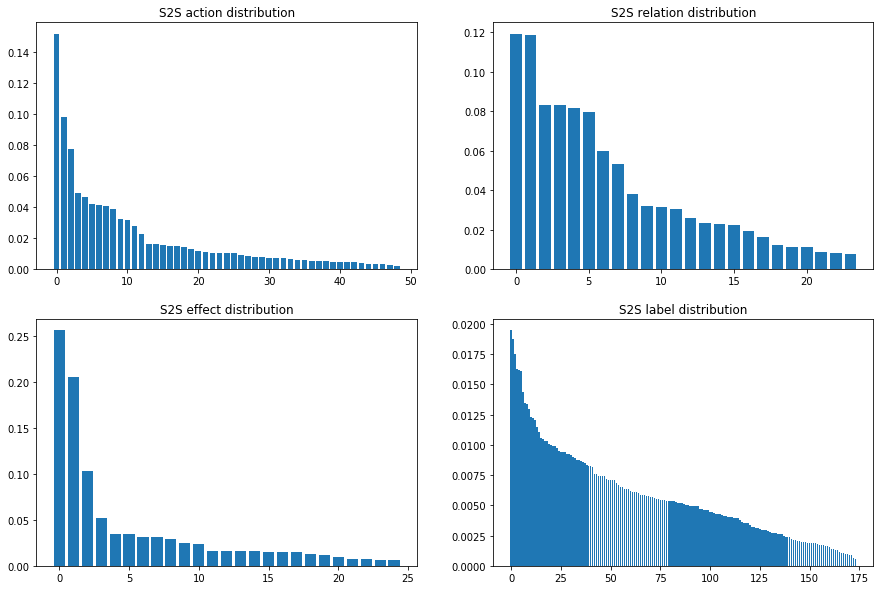

In [66]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.subplot(221)
plot_column_distribution('action')
plt.subplot(222)
plot_column_distribution('relation')
plt.subplot(223)
plot_column_distribution('effect')
plt.subplot(224)
plot_column_distribution('label')